# Imports

In [74]:
!pip install pandas
!pip install numpy
!pip install torch

In [75]:
!pip install matplotlib

In [76]:
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Hyper Paremeters Settings

In [77]:
### Dataset paramenters
ratio_training = 0.7

### Model parameters

# hidden dimension, They didn't tell us the value of `d`
h_dim = 12

# Maxium long-term preference that model can handle
n = 14
# Feature weight
w = 12 # [8, 16, 32, 64]
# Maxium short-term preference.
k = 4 # [2, 3, 4, 5, 6]

# Data Processing

In [78]:
# We are using Gowalla dataset.
# https://snap.stanford.edu/data/loc-gowalla.html
df = pd.read_csv("Gowalla_totalCheckins.txt", sep="\t", header=None)
df.columns = ["user", "check_in_time", "latitude", "longitude", "location"]

# We don't need these.
df = df.drop(columns=["check_in_time", "latitude", "longitude"])
df

,user,location
0,0,22847
1,0,420315
2,0,316637
3,0,16516
4,0,5535878
...,...,...
6442887,196578,906885
6442888,196578,965121
6442889,196578,1174322
6442890,196585,471724


In [79]:
df = df.head(100_000)
df

,user,location
0,0,22847
1,0,420315
2,0,316637
3,0,16516
4,0,5535878
...,...,...
99995,340,150784
99996,340,783443
99997,340,150621
99998,340,783443


In [80]:
# Remove location with less than 10 interactions.
location_to_user = df.groupby("location")["user"].apply(set).apply(list)

valid_location = location_to_user[location_to_user.apply(len) > 9].index

df2 = df[df["location"].isin(valid_location)]

df2

,user,location
1,0,420315
2,0,316637
3,0,16516
5,0,15372
6,0,21714
...,...,...
99389,339,26428
99414,339,26428
99500,339,9777
99546,339,26428


In [81]:
# User must have more than 15 interactions
user_to_location = df2.groupby('user')['location'].apply(list)

valid_user = user_to_location[user_to_location.apply(len) > 14].index

df3 = df2[df2["user"].isin(valid_user)]

df3

,user,location
1,0,420315
2,0,316637
3,0,16516
5,0,15372
6,0,21714
...,...,...
99074,337,672270
99075,337,671698
99123,337,689421
99133,337,99483


In [82]:
len_user = df3['user'].nunique()
len_item = df3["location"].nunique()

len_user, len_item

(149, 318)

In [83]:
# Map location id to normalized one
# So embedding actually works lol
sorted_locations = sorted(list(set(df3["location"].values)))

loc_norm = dict(zip(sorted_locations, range(len_item)))

In [84]:
df3["location"] = df3["location"].apply(lambda x: loc_norm[x])
df3

C:\Users\nutte\AppData\Local\Temp\ipykernel_17056\3282074892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["location"] = df3["location"].apply(lambda x: loc_norm[x])


,user,location
1,0,288
2,0,286
3,0,154
5,0,143
6,0,190
...,...,...
99074,337,298
99075,337,294
99123,337,305
99133,337,269


In [85]:
dataset = df3.groupby('user')['location'].apply(list).reset_index()
dataset

,user,location
0,0,"[288, 286, 154, 143, 190, 288, 288, 196, 138, ..."
1,4,"[132, 88, 253, 253, 253, 253, 313, 253, 253, 1..."
2,7,"[288, 288, 190, 288, 249, 288, 288, 26, 82, 22..."
3,15,"[106, 106, 196, 234, 195, 195, 52, 166, 257, 2..."
4,19,"[176, 52, 57, 52, 57, 69, 256, 38, 20, 176, 94..."
...,...,...
144,332,"[128, 181, 8, 270, 133, 64, 81, 130, 13, 3, 55..."
145,334,"[98, 87, 314, 248, 35, 36, 20, 225, 20, 35, 87..."
146,335,"[190, 288, 190, 190, 288, 190, 262, 190, 262, ..."
147,336,"[272, 106, 126, 126, 112, 310, 310, 233, 87, 1..."


In [ ]:
class DataGenerator:
    def __init__(self, df, training: bool):
        self.rows = []
        self.total = 0
        self.training  = training
        
        for _, r in df[['user', 'location']].iterrows():
            seq = r['location']
            for i in range(0, len(seq)-n):
                self.rows.append(
                    (seq[i:i+n], seq[i+n])
                )
                self.total += 1
        
        self.maxium = int(self.total * ratio_training)
        print(self.total, self.maxium)
        
    def set_training(self, bool=False):
        self.training = bool
    
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        if idx > self.maxium and self.training:
            raise StopIteration
        elif not self.training:
            idx += self.maxium + 1
        # This shit is so cursed
        if idx >= self.total:
            raise StopIteration
        
        inp, tgt = self.rows[idx]
        return torch.tensor(inp, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

In [87]:
dataloader = DataGenerator(dataset, True)

9384 6568


# Model

In [ ]:
import torch
import torch.nn as nn
import math

torch.manual_seed(0)

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len_item, h_dim)
        
        self.sigmoid = nn.Sigmoid()
        # Weight input gate
        self.w_i = nn.Linear(h_dim * 2, h_dim, bias=True) # 2H x H
        
        # Weight forget gate
        self.w_f = nn.Linear(h_dim * 2, h_dim, bias=True) # 2H x H

        self.tanh = nn.Tanh()
        
        # Weight cell state
        self.w_c = nn.Linear(h_dim * 2, h_dim, bias=True) # 2H x H
        
        
        # Weight output gate
        self.w_o = nn.Linear(h_dim * 2, h_dim, bias=True) # 2H x H
        
        self.sigmoid = nn.Sigmoid()
        
        self.relu = nn.ReLU()
        
        # Convolutional layer
        self.horiz_conv = nn.Conv1d(
            in_channels=h_dim, out_channels=n, kernel_size=w, stride=h_dim
        )

        self.vert_layer = nn.Linear(k, 1, bias=True)
        
        self.super_fucking_w = nn.Linear(h_dim * 2 + n, len_item)

    def forward(self, items: list[int]):
        item_embed = self.embedding(torch.tensor(items)) # H x |[I_U]|\

        last_c = torch.zeros(h_dim) # H x 1
        last_h = torch.zeros(h_dim) # H x 1
        hs = [last_h, ]

        for item in item_embed:
            # Recurrent layer
            hx = torch.cat([hs[-1], item], 0) # 2H x 1
            i = self.sigmoid(self.w_i(hx))
            f = self.sigmoid(self.w_f(hx))
            new_c = self.tanh(self.w_c(hx))
            c = torch.mul(f, last_c) + torch.mul(i, new_c)
            o = self.sigmoid(self.w_o(hx))
            h = torch.mul(o, self.tanh(c))

            hs.append(h)
            last_c = c

        hs = torch.stack(hs[1:])

        # Horizontal conv
        o_t = self.relu(self.horiz_conv(hs.transpose(0, 1)).transpose(0, 1)[0])

        # Vertical conv
        last_k_hs = hs[-k:].T
        v_tilda_t = self.relu(self.vert_layer(last_k_hs)).T
        o_tilda_t = torch.mul(v_tilda_t, hs[-1])[0]

        # Fully-connected layer
        concat = torch.cat([o_t, hs[-1], o_tilda_t], 0)
        # print(concat)
        y_u_t = self.sigmoid(self.super_fucking_w(concat))
        # What am i even doing
        return y_u_t

In [89]:
def one_hot(target):
    zeroes = torch.zeros(len_item)
    zeroes[target] = 1
    return zeroes

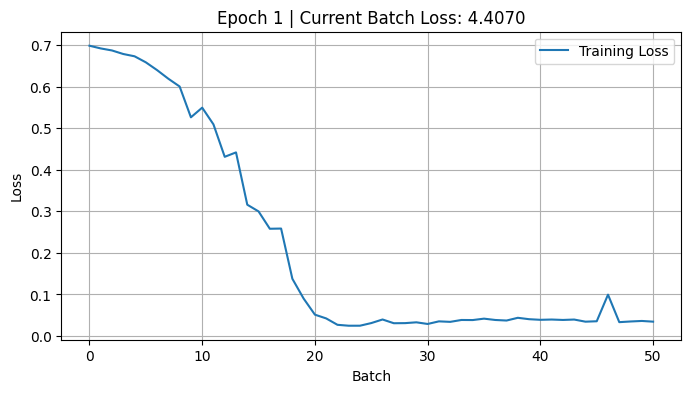

Loss: 0.0276


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

torch.manual_seed(0)

loss_history = []
plt.ion()

dataloader.set_training(True)

model = RCNN()
# model.load_state_dict(torch.load("rcnn_weights.pth"))
epoches = 1

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=0.001)
i = 0
batch = 128

for epoch in range(epoches):
    for data in dataloader:
        if i == 0:
            total_loss = 0
            optimizer.zero_grad()

        items, target = data
        logits = model(items)

        assert 0 <= target < len_item
        # target = torch.tensor([target], dtype=torch.long)
        target = one_hot(target)

        loss = criterion(logits, target)
        
        total_loss += loss
        
        # WTF IS THIS BATCH SYSTEM. FUCK ME
        if i == batch-1:
            total_loss.backward()
            optimizer.step()

            loss_history.append(total_loss.item()/batch)

            # Re-draw the plot
            clear_output(wait=True)
            plt.figure(figsize=(8,4))
            plt.plot(loss_history, label="Training Loss")
            # plt.yscale("log")
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.title(f"Epoch {epoch+1} | Current Batch Loss: {total_loss.item():.4f}")
            plt.legend()
            plt.grid(True)
            plt.show()
            print(f"\rLoss: {loss.item():.4f}", flush=True)
            
        i += 1
        i %= batch

In [91]:
torch.save(model.state_dict(), "rcnn_weights.pth")

In [92]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-1.0328, -0.9909, -0.1838,  ..., -1.0892,  0.2798,  0.2369],
                      [ 0.0304,  1.2266,  1.0137,  ..., -1.4479, -0.2589,  1.8199],
                      [ 0.6931, -0.5217, -0.1504,  ...,  0.0251, -0.4262,  0.2082],
                      ...,
                      [ 0.1901,  1.2938,  0.9365,  ..., -1.0179, -0.2448,  2.6257],
                      [-1.2004, -0.4435,  0.2255,  ...,  0.0740,  1.0455, -0.0357],
                      [ 0.7684,  0.0126, -0.5655,  ..., -1.6820, -0.2105, -1.5571]])),
             ('w_i.weight',
              tensor([[-0.1149,  0.1374, -0.1647, -0.1733,  0.1406,  0.0226, -0.0492, -0.0502,
                       -0.2002, -0.1388, -0.0812,  0.1680,  0.1329,  0.1209, -0.1345,  0.2255,
                       -0.0822, -0.0182,  0.0382,  0.0158,  0.1360,  0.0693,  0.1940,  0.1308],
                      [ 0.1303, -0.1896,  0.2397, -0.0618,  0.2609,  0.0535, -0.0425, -0.0816,
                       

In [ ]:
# With seed set to 0
# 100k interactions, 2 epoch
# 0.023?, λ = 0
# 0.0297, λ = 0.0001
# 0.0298, λ = 0.001
# 0.0298, λ = 0.01
# 0.0230, λ = 0.1

# Testing the Model

In [ ]:
# HitRatio
hr_n = 5

hr_total = 0
hr_hits = 0
aps = []

dataloader.set_training(False)

def hitratio(target, indices):
    return 1 if target in indices[:hr_n] else 0

def mAP(target, indices):
    # magic trick! (srry future me)
    # https://stackoverflow.com/questions/47863001/how-pytorch-tensor-get-the-index-of-specific-value
    rank = (indices == target).nonzero(as_tuple=True)[0].item() + 1
    return 1/rank

for data in dataloader:
    items, target = data

    predictions = model(items)
    best_y, indices = torch.sort(predictions, descending=True)
    
    hr_hits += hitratio(target, indices)
    aps.append(mAP(target, indices))
    hr_total += 1
    

print(f"Hit Ratio@{hr_n}: {hr_hits/hr_total:.4f} ({hr_hits}/{hr_total})")
print(f"mAP: {(sum(aps)/len(aps)):.4f}")

C:\Users\nutte\AppData\Local\Temp\ipykernel_17056\3475040872.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item_embed = self.embedding(torch.tensor(items)) # H x |[I_U]|\


Hit Ratio@5: 0.1929 (543/2815)
mAP: 0.1036


In [ ]:
# Fixed random seed
# Fixed Learning Rate = 5e-3
# Fixed λ = 0.001
# Fixed training ratio = 0.7

# 100k interactions, 1 epoch
# Hit Ratio@5: 0.1929 (543/2815)
# mAP: 0.1036

# 100k interactions, 2 epoch
# Hit Ratio@5: 0.1492 (420/2815)
# mAP: 0.0951

# 200k interactions, 1 epoch
# Hit Ratio@5: 0.0484 (417/8608)
# mAP: 0.0357

# 200k interactions, 2 epoch
# Hit Ratio@5: 0.0670 (577/8608)
# mAP: 0.0423